In [1]:
import utils
import flower_photos_data
import vgg16
import tensorflow as tf
import numpy as np
from os.path import isfile, isdir
import os

In [2]:
label_dict ={0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [3]:
def process_data():
    images, labels, label_dict = flower_photos_data.load_flower_datasets()
    assert np.max(images[0])<=1, 'The image should be scaled to 0-1'
    images, labels = utils.shuffle_data(images, labels)
    labels_onehot = utils.one_hot_encode(labels)
    train_images, train_labels, valid_images, valid_labels, test_images, test_labels = \
        utils.split_data(images, labels_onehot, train_size=0.8, valid_size=0.1, test_size=0.1)
    os.mkdir('data/flower_npy')
    np.save('data/flower_npy/train_images.npy', train_images)
    np.save('data/flower_npy/train_labels.npy', train_labels)
    np.save('data/flower_npy/valid_images.npy', valid_images)
    np.save('data/flower_npy/valid_labels.npy', valid_labels)
    np.save('data/flower_npy/test_images.npy', test_images)
    np.save('data/flower_npy/test_labels.npy', test_labels)

In [4]:
if not isdir('data/flower_npy'):
    process_data()
train_images = np.load('data/flower_npy/train_images.npy')
train_labels = np.load('data/flower_npy/train_labels.npy')
valid_images = np.load('data/flower_npy/valid_images.npy')
valid_labels = np.load('data/flower_npy/valid_labels.npy')
print("Train images: {}, labels: {}".format(train_images.shape, train_labels.shape))
print("Valid images: {}, labels: {}".format(valid_images.shape, valid_labels.shape))

Train images: (2000, 224, 224, 3), labels: (2000, 5)
Valid images: (250, 224, 224, 3), labels: (250, 5)


In [5]:
inputs_ = tf.placeholder(dtype=tf.float32, shape=[None, 224,224,3], name='inputs')
labels_ = tf.placeholder(dtype=tf.float32, shape=[None,len(label_dict)], name='labels')

In [6]:
vgg = vgg16.Vgg16()
vgg.build_nn(inputs_)

vgg16 parameters loaded!
conv1_1 : (?, 224, 224, 64)
conv1_2 : (?, 224, 224, 64)
max_pool1 : (?, 112, 112, 64)
conv2_1 : (?, 112, 112, 128)
conv2_2 : (?, 112, 112, 128)
max_pool2 : (?, 56, 56, 128)
conv3_1 : (?, 56, 56, 256)
conv3_2 : (?, 56, 56, 256)
conv3_3 : (?, 56, 56, 256)
max_pool3 : (?, 28, 28, 256)
conv4_1 : (?, 28, 28, 512)
conv4_2 : (?, 28, 28, 512)
conv4_3 : (?, 28, 28, 512)
max_pool4 : (?, 14, 14, 512)
conv5_1 : (?, 14, 14, 512)
conv5_2 : (?, 14, 14, 512)
conv5_3 : (?, 14, 14, 512)
max_pool5 : (?, 7, 7, 512)
fc6 : (?, 4096)
fc7 : (?, 4096)
fc8 : (?, 1000)


In [14]:
hidden = tf.contrib.layers.fully_connected(vgg.relu6, 256, activation_fn = tf.nn.relu)
logits = tf.contrib.layers.fully_connected(hidden, len(label_dict), activation_fn = None)
prediction = tf.nn.softmax(logits)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))

compare = tf.equal(tf.argmax(prediction,axis=1), tf.argmax(labels_, axis=1))
accuracy = tf.reduce_mean(tf.cast(compare, dtype=tf.float32))

optimizer = tf.train.AdadeltaOptimizer(0.05).minimize(cost)

saver = tf.train.Saver()

In [15]:
epoches = 10
iteration = 0
predict =[]

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Start training ...... ')
    for e in range(epoches):
        for batch_images, batch_labels in utils.get_batches(train_images, train_labels, n_batches=20):
            iteration += 1
            loss,  _ = sess.run([cost,  optimizer],
                               feed_dict={inputs_:batch_images, labels_:batch_labels})
            print("Epoch: {}/{}".format(e+1, epoches),
                  "Iteration: {}".format(iteration),
                  "Train loss: {:.5f}".format(loss))
            if iteration%10==0:
                val_acc, predict = sess.run([accuracy, prediction], feed_dict={inputs_:valid_images[:100], labels_:valid_labels[:100]})
                print("-------------------")
                print("Epoch: {}/{}".format(e+1, epoches),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
                print("-------------------")

    saver.save(sess, "data/flower_checkpoints/flowers.ckpt")

Start training ...... 
Epoch: 1/10 Iteration: 1 Train loss: 5.64759
Epoch: 1/10 Iteration: 2 Train loss: 5.16116
Epoch: 1/10 Iteration: 3 Train loss: 5.00958
Epoch: 1/10 Iteration: 4 Train loss: 5.02702
Epoch: 1/10 Iteration: 5 Train loss: 3.67188
Epoch: 1/10 Iteration: 6 Train loss: 4.10446
Epoch: 1/10 Iteration: 7 Train loss: 3.71512
Epoch: 1/10 Iteration: 8 Train loss: 3.02103
Epoch: 1/10 Iteration: 9 Train loss: 3.50482
Epoch: 1/10 Iteration: 10 Train loss: 2.73017
-------------------
Epoch: 1/10 Iteration: 10 Validation Acc: 0.3400
-------------------
Epoch: 1/10 Iteration: 11 Train loss: 3.19154
Epoch: 1/10 Iteration: 12 Train loss: 2.42021
Epoch: 1/10 Iteration: 13 Train loss: 3.42358
Epoch: 1/10 Iteration: 14 Train loss: 3.27555
Epoch: 1/10 Iteration: 15 Train loss: 3.29779
Epoch: 1/10 Iteration: 16 Train loss: 2.59102
Epoch: 1/10 Iteration: 17 Train loss: 2.50992
Epoch: 1/10 Iteration: 18 Train loss: 2.49617
Epoch: 1/10 Iteration: 19 Train loss: 1.95176
Epoch: 1/10 Iteration: 

-------------------
Epoch: 8/10 Iteration: 150 Validation Acc: 0.7100
-------------------
Epoch: 8/10 Iteration: 151 Train loss: 0.51317
Epoch: 8/10 Iteration: 152 Train loss: 0.37940
Epoch: 8/10 Iteration: 153 Train loss: 0.56682
Epoch: 8/10 Iteration: 154 Train loss: 0.69373
Epoch: 8/10 Iteration: 155 Train loss: 0.41929
Epoch: 8/10 Iteration: 156 Train loss: 0.40223
Epoch: 8/10 Iteration: 157 Train loss: 0.45068
Epoch: 8/10 Iteration: 158 Train loss: 0.72295
Epoch: 8/10 Iteration: 159 Train loss: 0.45366
Epoch: 8/10 Iteration: 160 Train loss: 0.47242
-------------------
Epoch: 8/10 Iteration: 160 Validation Acc: 0.7200
-------------------
Epoch: 9/10 Iteration: 161 Train loss: 0.45515
Epoch: 9/10 Iteration: 162 Train loss: 0.47596
Epoch: 9/10 Iteration: 163 Train loss: 0.37612
Epoch: 9/10 Iteration: 164 Train loss: 0.53986
Epoch: 9/10 Iteration: 165 Train loss: 0.32251
Epoch: 9/10 Iteration: 166 Train loss: 0.48917
Epoch: 9/10 Iteration: 167 Train loss: 0.33128
Epoch: 9/10 Iteration

In [17]:
test_images = np.load('data/flower_npy/test_images.npy')
test_labels = np.load('data/flower_npy/test_labels.npy')
print("Test images: {}, labels: {}".format(test_images.shape, test_labels.shape))

Test images: (250, 224, 224, 3), labels: (250, 5)


In [18]:
with tf.Session() as sess:
    print('Restoring parameters ......')
    saver.restore(sess, tf.train.latest_checkpoint('data/flower_checkpoints'))
    predict, acc = sess.run([prediction, accuracy], feed_dict={inputs_:test_images[:100], labels_:test_labels[:100]})
    print(acc)

Restoring parameters ......
INFO:tensorflow:Restoring parameters from data/flower_checkpoints/flowers.ckpt
0.77


The fist 9 images: ['daisy', 'roses', 'sunflowers', 'dandelion', 'sunflowers', 'tulips', 'sunflowers', 'sunflowers', 'roses']
Prediction: ['dandelion', 'roses', 'sunflowers', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'daisy', 'roses']


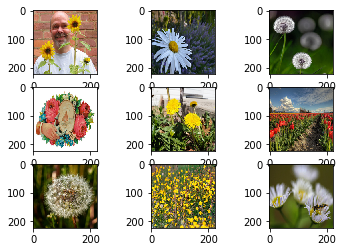

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

print('The fist 9 images: {}'.format([label_dict[i] for i in np.argmax(test_labels[:9],axis=1)]))
print('Prediction: {}'.format([label_dict[i] for i in np.argmax(predict[:9],axis=1)]))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[i])
plt.show()